In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
PATH_TO_DATA = './data/'
os.listdir(PATH_TO_DATA)

['train_labels.csv', 'rsna-brain-tumor-data']

In [3]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
print(train_labels_df.shape)
train_labels_df.head()

(585, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [4]:
value_counts = train_labels_df['MGMT_value'].value_counts()
value_counts

1    307
0    278
Name: MGMT_value, dtype: int64

<AxesSubplot:>

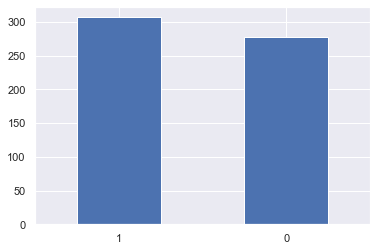

In [5]:
# plt.figure(figsize=(7,5))
value_counts.plot(kind='bar', rot=0)

<AxesSubplot:>

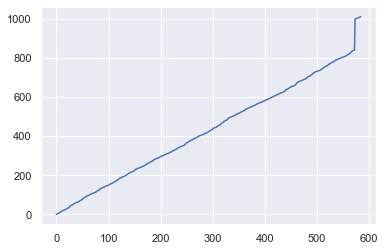

In [6]:
train_labels_df['BraTS21ID'].plot()

# Read images

In [7]:
IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')
IMG_PATH_TRAIN

'./data/rsna-brain-tumor-data/train'

In [8]:
from PIL import Image
import cv2

## Read one image

In [9]:
case_idx = 20
case_id = train_labels_df['BraTS21ID'][case_idx]
# case_id = f'{case_id:05d}'
case_id = f'{case_id:0>5d}'
case_id

'00030'

In [10]:
# - FLAIR
# - T1w
# - T1wCE
# - T2w
MRI_TYPE = 'FLAIR'

images_path = os.path.join(IMG_PATH_TRAIN, case_id, MRI_TYPE)
images_path

'./data/rsna-brain-tumor-data/train/00030/FLAIR'

In [11]:
image_number = 5
image_name = os.listdir(images_path)[image_number]
# sorted(os.listdir(images_path))
image_name

'Image-444.png'

In [12]:
image_path = os.path.join(images_path, image_name)
image_path

'./data/rsna-brain-tumor-data/train/00030/FLAIR/Image-444.png'

In [76]:
# image = cv2.imread(image_path)
# image.shape

In [13]:
image = Image.open(image_path)
np.array(image).shape

(512, 512)

In [19]:
512*512

262144

In [24]:
np.array(image)[256,256:266]

array([59, 60, 61, 63, 64, 65, 66, 68, 68, 68], dtype=uint8)

In [20]:
# image
a, b = np.where(image)
a.shape, b.shape

((60467,), (60467,))

In [26]:
rows, cols = np.nonzero(image)

xmin = np.min(cols)
xmax = np.max(cols)
ymin = np.min(rows)
ymax = np.max(rows)

xmin, xmax, ymin, ymax

(93, 422, 107, 375)

In [28]:
image_crop = np.array(image)[ymin:ymax, xmin:xmax]
image_crop.shape

(268, 329)

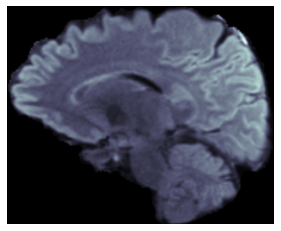

In [29]:
show_image(image_crop)

In [14]:
def show_image(image):
    # plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.axis('off')
#     plt.imshow(image)
    plt.imshow(image, cmap='bone') # gray, bone
    plt.show()

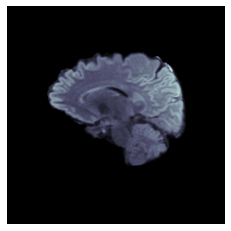

In [15]:
show_image(image)

## Image3DDataset

In [48]:
from dataset import Image3DDataset
from plot_utils import show_image_3d

In [45]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [32]:
from torchvision import transforms as T

IMG_SIZE = 256

def get_train_transform(img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
#         T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [68]:
max_depth = 64
train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN, max_depth, get_train_transform(IMG_SIZE))
# train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN, max_depth)
len(train_dataset)

585

In [69]:
image, label = train_dataset[143] # 580
image.shape, label

(28, 320, 320)
(60, 44) (258, 280)
(28, 236, 198)
(28, 256, 256)


((1, 64, 256, 256), 0)

shape: (64, 256, 256)


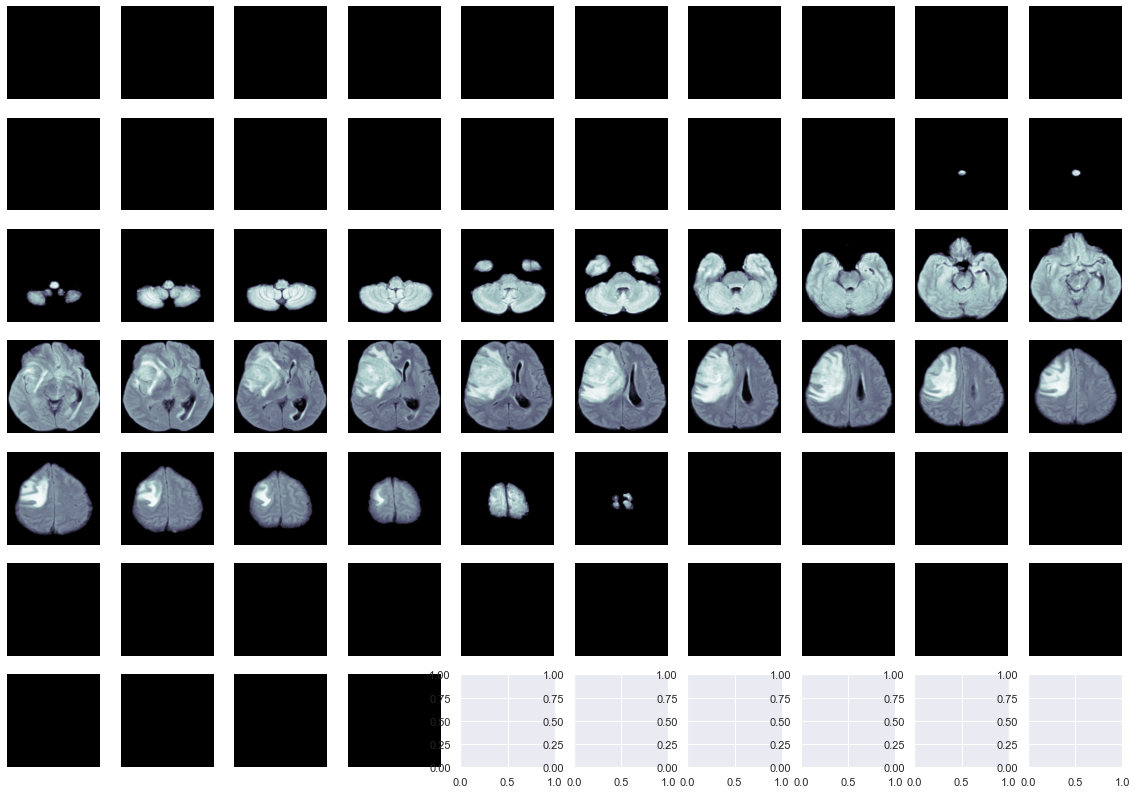

In [70]:
show_image_3d(image)

# Num of images per MRI type

In [71]:
train_labels_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [72]:
# 00109 - no FLAIR
# 00123 - no T1w
# 00709 - no FLAIR

print(train_labels_df.shape)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 109].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 709].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 123].index)
print(train_labels_df.shape)

(585, 2)
(582, 2)


In [73]:
def row_to_mri_type_count(row, mri_type):
    case_id = row['BraTS21ID']
    case_id = f'{case_id:0>5d}'
    images_path = os.path.join(IMG_PATH_TRAIN, case_id, mri_type)   
    count = len(os.listdir(images_path))
       
    return count

In [74]:
MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def get_mri_count():
    for mri_type in MRI_TYPES:
        train_labels_df[f'{mri_type}_count'] = train_labels_df.apply(
            lambda row: row_to_mri_type_count(row, mri_type),
            axis=1
        )
        
get_mri_count()

In [75]:
train_labels_df

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,0,1,288,29,86,274
1,2,1,67,27,88,269
2,3,0,71,28,88,285
3,5,1,277,26,83,272
4,6,1,68,28,89,270
...,...,...,...,...,...,...
580,1005,1,21,21,21,21
581,1007,1,114,114,114,114
582,1008,1,45,137,138,47
583,1009,0,22,22,22,22


In [77]:
train_labels_df[train_labels_df['FLAIR_count']==14]

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
391,571,0,14,15,15,16
560,818,0,14,27,27,28


In [76]:
train_labels_df['FLAIR_count'].min()

14

<AxesSubplot:>

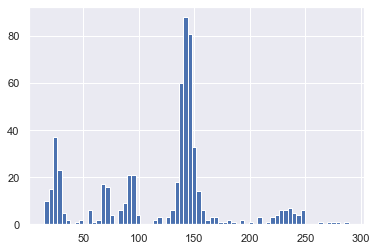

In [226]:
# plt.hist(train_labels_df['FLAIR_count'], bins=100)
# plt.show()

train_labels_df['T1wCE_count'].hist(bins=70)

In [218]:
# train_labels_df['FLAIR_count'].value_counts()

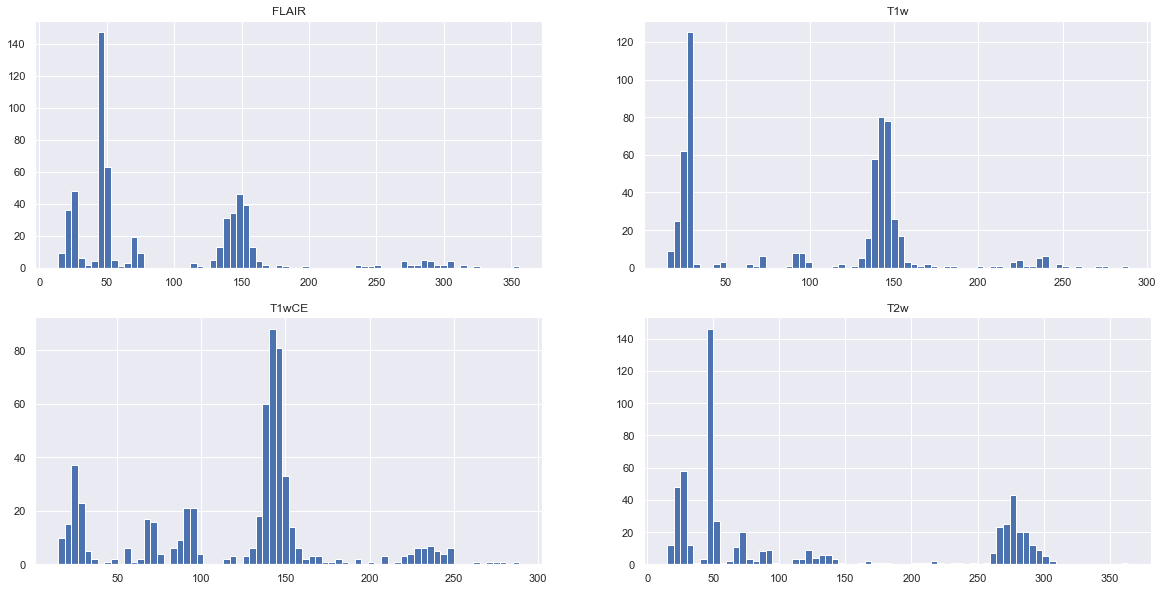

In [225]:
_, axes = plt.subplots(2, 2, figsize=(20,10))

axes = axes.flatten()
    
for i, ax in enumerate(axes):
    mri_type = MRI_TYPES[i]  
     
    ax.set_title(mri_type)
    ax.hist(train_labels_df[f'{mri_type}_count'], bins=70)

# Image sizes